In [18]:
import os
base_dir= r"C:\Vedha\miniproject\training"  
labels=[]
for folder in os.listdir(base_dir):
    folder_path=os.path.join(base_dir,folder)
    if not os.path.isdir(folder_path):
        continue
    for file in os.listdir(folder_path):
        if file.lower().endswith("hea"):
            with open(os.path.join(folder_path,file),"r")as f:
                    last_line=f.readlines()[-1].strip().lower()
                    labels.append(last_line)
print(set(labels))

{'# normal', '# abnormal'}


In [3]:
import os
import librosa
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier

# Recursively Load Data 
def load_all_data(base_dir):
    X, y = [], []
    count = 0

    # Walk through all subfolders
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.lower().endswith(".hea"):
                hea_path = os.path.join(root, file)
                try:
                    with open(hea_path, "r") as f:
                        last_line = f.readlines()[-1].strip().lower()
                        if "# normal" in last_line:
                            label = 0
                        elif "# abnormal" in last_line:
                            label = 1
                        else:
                            continue
                except Exception as e:
                    print("Skipping file:", hea_path, "Error:", e)
                    continue

                # Find matching .wav file
                wav_file = file.replace(".hea", ".wav")
                wav_path = os.path.join(root, wav_file)
                if not os.path.exists(wav_path):
                    print("Missing WAV file:", wav_path)
                    continue

                try:
                    # Extract MFCC features
                    signal, sr = librosa.load(wav_path, sr=None)
                    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=20)
                    feat = np.concatenate([np.mean(mfcc, axis=1), np.std(mfcc, axis=1)])
                    X.append(feat)
                    y.append(label)

                    count += 1
                    if count % 50 == 0:
                        print(f"Processed {count} files...")
                except Exception as e:
                    print("Skipping WAV file:", wav_path, "Error:", e)
                    continue

    return np.array(X), np.array(y)

# Load Dataset
base_dir = r"C:\Vedha\miniproject\training"  # parent folder containing training-a to f
X, y = load_all_data(base_dir)

print("✅ Dataset size:", X.shape, y.shape)
print("✅ Label distribution:", Counter(y))

if len(X) == 0:
    raise ValueError("No samples found! Check your folder structure and file names.")

# Split Train-Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# XGBoost
xgb = XGBClassifier(eval_metric="logloss", use_label_encoder=False)

# Parameter Grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 5],
    "learning_rate": [0.01, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

# Grid Search
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring="accuracy",
    cv=3,
    verbose=2,
    n_jobs=-1,
    error_score="raise"  # immediately raise errors if any
)

grid.fit(X_train, y_train)

print("\n✅ Best Parameters:", grid.best_params_)
print("✅ Best Cross-Validation Accuracy:", grid.best_score_)

# Evaluate
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("\n✅ Test Accuracy:", accuracy_score(y_test, y_pred))
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=["Normal", "Abnormal"]))


Processed 50 files...
Processed 100 files...
Processed 150 files...
Processed 200 files...
Processed 250 files...
Processed 300 files...
Processed 350 files...
Processed 400 files...
Processed 450 files...
Processed 500 files...
Processed 550 files...
Processed 600 files...
Processed 650 files...
Processed 700 files...
Processed 750 files...
Processed 800 files...
Processed 850 files...
Processed 900 files...
Processed 950 files...
Processed 1000 files...
Processed 1050 files...
Processed 1100 files...
Processed 1150 files...
Processed 1200 files...
Processed 1250 files...
Processed 1300 files...
Processed 1350 files...
Processed 1400 files...
Processed 1450 files...
Processed 1500 files...
Processed 1550 files...
Processed 1600 files...
Processed 1650 files...
Processed 1700 files...
Processed 1750 files...
Processed 1800 files...
Processed 1850 files...
Processed 1900 files...
Processed 1950 files...
Processed 2000 files...
Processed 2050 files...
Processed 2100 files...
Processed 21

C:\Users\rpran\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:55:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



✅ Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
✅ Best Cross-Validation Accuracy: 0.9043209876543209

✅ Test Accuracy: 0.9290123456790124

✅ Classification Report:
               precision    recall  f1-score   support

      Normal       0.95      0.96      0.96       515
    Abnormal       0.85      0.80      0.82       133

    accuracy                           0.93       648
   macro avg       0.90      0.88      0.89       648
weighted avg       0.93      0.93      0.93       648



In [4]:
import pickle
import os
save_path=r"C:\Vedha\miniproject\xgb_model.pkl"
with open(save_path,"wb")as f:
    pickle.dump(best_model,f)
print("Model saved at:",save_path)

Model saved at: C:\Vedha\miniproject\xgb_model.pkl


In [5]:
with open(r"C:\Vedha\miniproject\xgb_model.pkl","rb")as f:
    loaded_model=pickle.load(f)

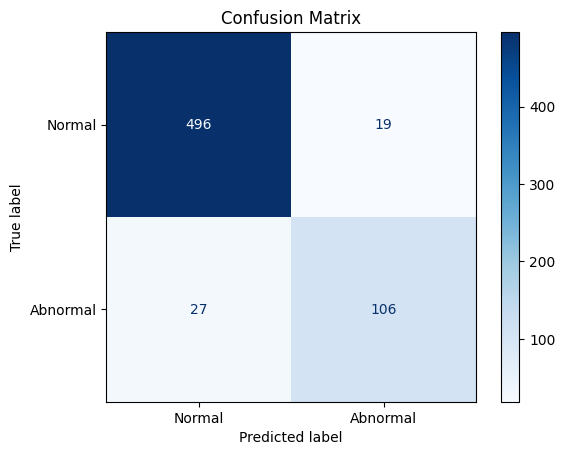

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, loaded_model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Abnormal"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()



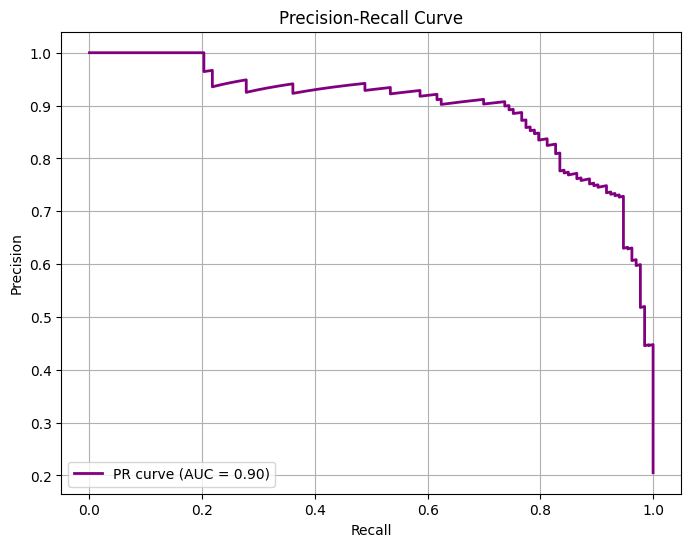

In [9]:
from sklearn.metrics import precision_recall_curve, auc

y_prob = loaded_model.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, color='purple', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


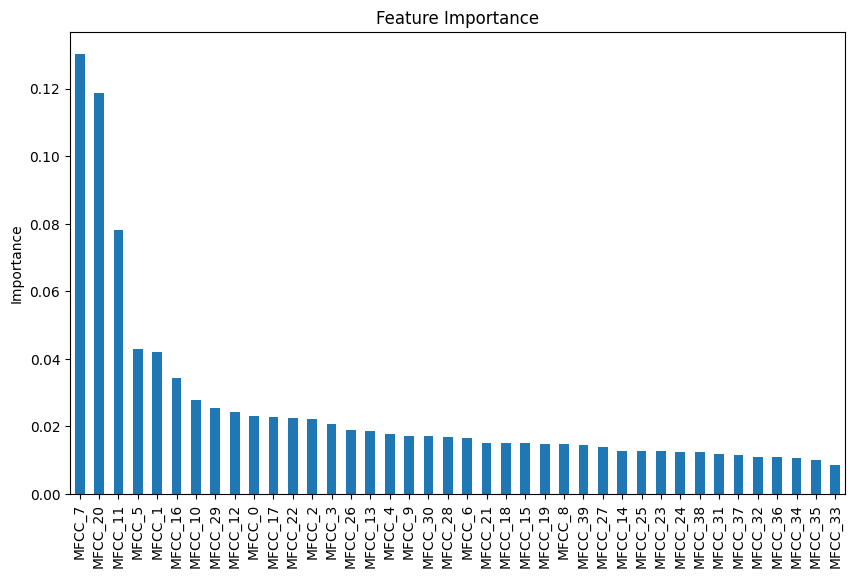

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature importance
importance = loaded_model.feature_importances_
feature_names = [f'MFCC_{i}' for i in range(len(importance))]

feat_imp = pd.Series(importance, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_imp.plot(kind='bar')
plt.title('Feature Importance')
plt.ylabel('Importance')
plt.show()


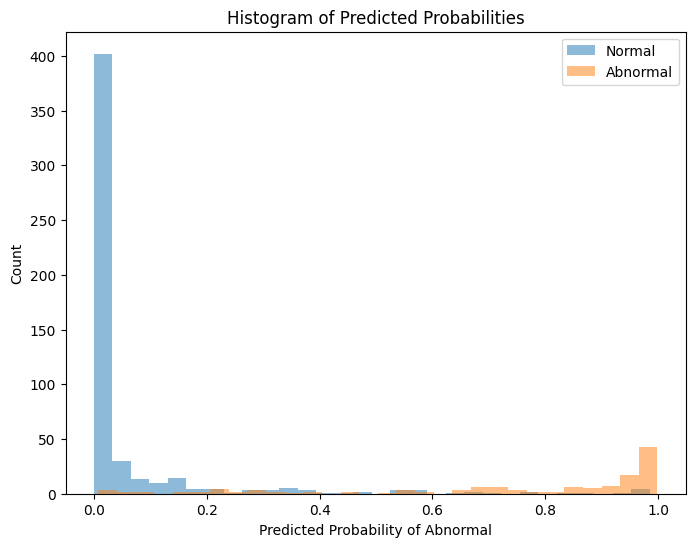

In [11]:
plt.figure(figsize=(8,6))
plt.hist(y_prob[y_test==0], bins=30, alpha=0.5, label='Normal')
plt.hist(y_prob[y_test==1], bins=30, alpha=0.5, label='Abnormal')
plt.xlabel('Predicted Probability of Abnormal')
plt.ylabel('Count')
plt.title('Histogram of Predicted Probabilities')
plt.legend()
plt.show()


IndexError: index 1 is out of bounds for axis 1 with size 1

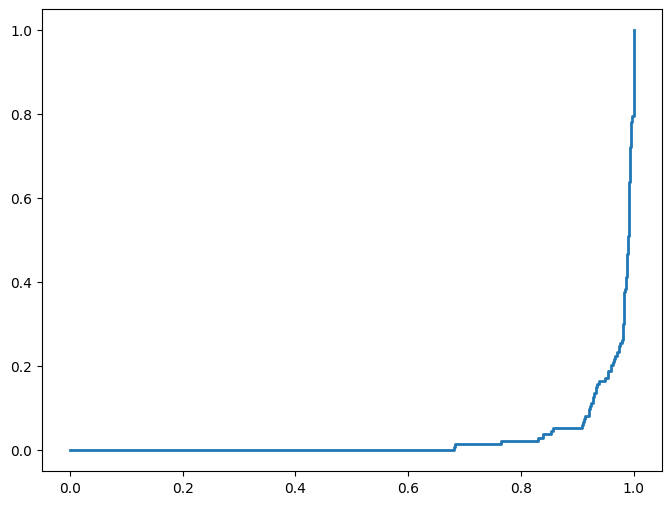

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Binarize the labels (necessary for multi-class ROC, works for binary too)
y_test_bin = label_binarize(y_test, classes=[0,1])

# Predict probabilities for both classes
y_prob = loaded_model.predict_proba(X_test)

# Initialize plot
plt.figure(figsize=(8,6))

# Loop over classes
for i, class_name in enumerate(["Normal", "Abnormal"]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    auc_score = roc_auc_score(y_test_bin[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {auc_score:.2f})')

# Plot random guess line
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Both Classes')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


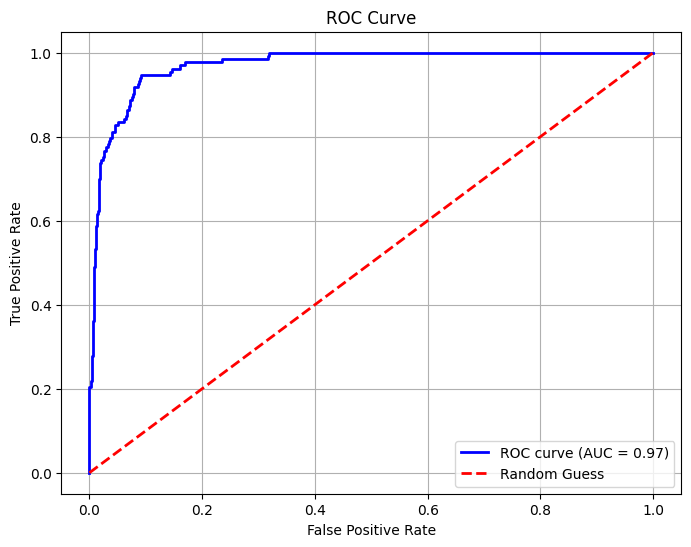

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get probability for positive class (Abnormal = 1)
y_prob = loaded_model.predict_proba(X_test)[:, 1]  # Only positive class

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)

# Compute AUC
auc_score = roc_auc_score(y_test, y_prob)

# Plot ROC
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, lw=2, color='blue', label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0,1], [0,1], color='red', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
